In [187]:

from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import metrics
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix, classification_report,log_loss
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import dalex as dx #explainer for our model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score

from sklearn import set_config; set_config(display='diagram')
import shap
np.random.seed(42)
ran = 42
seed = 42
scoring_reg ='neg_root_mean_squared_error'
scoring_clf ='roc_auc'


# Load Data

In [188]:
df = pd.read_csv("compas-scores-two-years-clean.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0


In [189]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

In [190]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df = df[columns]

To get a clearer picture, we will only use a few columns of the original data frame.


- demographics: "age", "age_cat", "sex", "race"
- criminal history: "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"
- current charges: "c_charge_degree","c_charge_desc"
- truth:"two_year_recid"


Drop duplicate

In [191]:
df.drop_duplicates()

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid
0,1,69,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Assault w/Firearm,Low,1,NaN,NaN,0
1,3,34,25 - 45,Male,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,Low,3,(F3),Felony Battery (Dom Strang),1
2,4,24,Less than 25,Male,African-American,0,0,1,4,F,Possession of Cocaine,Low,4,(M1),Driving Under The Influence,1
5,7,44,25 - 45,Male,Other,0,0,0,0,M,Battery,Low,1,NaN,NaN,0
6,8,41,25 - 45,Male,Caucasian,0,0,0,14,F,Possession Burglary Tools,Medium,6,(F2),Poss of Firearm by Convic Felo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,20,Less than 25,Male,African-American,0,0,0,0,F,Possession of Cocaine,High,9,NaN,NaN,0
6212,10996,23,Less than 25,Male,African-American,0,0,0,0,F,Deliver Cannabis,Medium,7,NaN,NaN,0
6213,10997,23,Less than 25,Male,African-American,0,0,0,0,F,Leaving the Scene of Accident,Low,3,NaN,NaN,0
6214,10999,57,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Battery / Pregnant,Low,1,NaN,NaN,0


Check dtype of data

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


### Feature Engineering: Create feature c_charge_degree_detailed

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee`
- The c_charge_desc contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [193]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df[df["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df[df["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and mapped them against the current charges

### Map charge degree to all cases and store in new feature column c_charge_degree_detailed

In [194]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [195]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df= df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df.reset_index(drop=True, inplace=True)

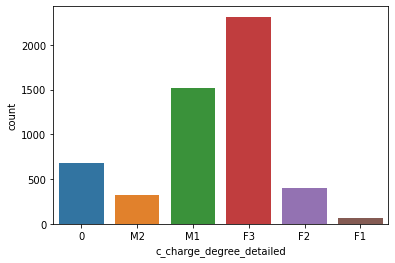

In [196]:
sns.countplot(x="c_charge_degree_detailed", data=df, order=["0","M2", "M1", "F3", "F2", "F1"])

In [197]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [198]:
index_nan_cases = df[df.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges.
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Data Preprocessing

### Initial distribution of the features

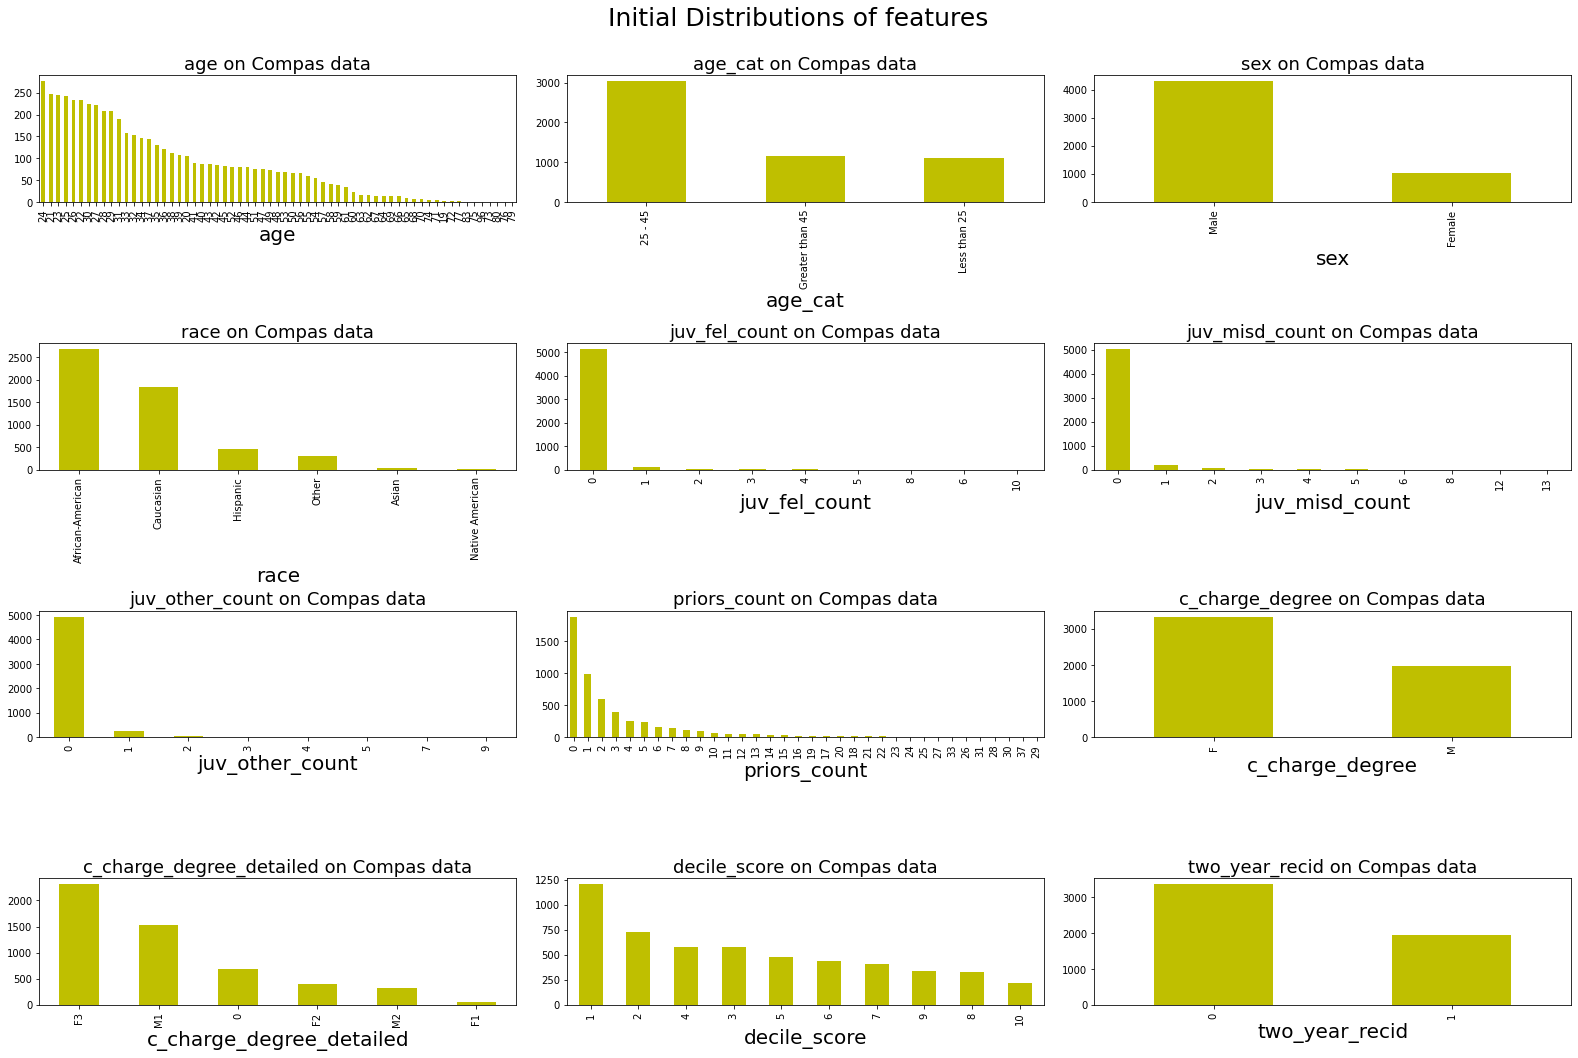

In [199]:

def plot_dist(col, ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Compas data".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(4,3, figsize = (22,15))
f.tight_layout(h_pad=12, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = [ "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_degree_detailed", #current charges
           "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "two_year_recid"]
k = 0
for i in range(4):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

Let us take a look closer into decile_score / race of African-American and Caucasian. 
The difference in scores leads to drastically different racial make-up per decile.

In [200]:
cols = ['race', 'decile_score']
df_race = df[cols].loc[lambda x:x['race'].isin(['African-American', 'Caucasian'])]

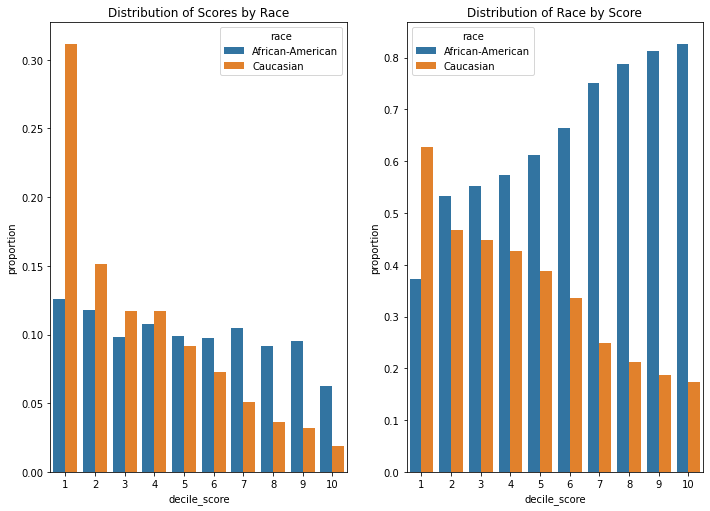

In [201]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(11.7, 8.27)
a1 = (
    df_race
    .groupby(['race'])['decile_score']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='decile_score')
)

sns.barplot(data=a1, x='decile_score' ,y='proportion',hue='race', ax=ax1)
ax1.set_title('Distribution of Scores by Race')

a2 = (
    df_race
    .groupby(['decile_score'])['race']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='race')
)

sns.barplot(data=a2, x='decile_score' ,y='proportion',hue='race', ax=ax2);
ax2.set_title('Distribution of Race by Score');

There is a big difference in distribution of race by score and another way around.
We decide to split the model into one with race and one without race.

### Fill in missing data for c_charge_degree_detailed

In [202]:
#fill missing data with mode as the value that appears the most in the set of values
df.fillna(df.c_charge_degree_detailed.mode().iloc[0], inplace=True)

In [203]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed


### Scaling

In [204]:
minmax_scaler = MinMaxScaler()


# Regression

## Selection of features for the model

### Model with race

#### Featuring and start fitting base model

**Featuring age cat**

In [205]:
features = pd.concat([pd.get_dummies(df.age_cat, prefix='age_cat',drop_first=True),
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = np.log(df.decile_score)

**Featuring scaling**

In [206]:
features= minmax_scaler.fit_transform(features)

**Featuring age**

In [207]:
features_age = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target_age = np.log(df.decile_score)

**Featuring scaling**

In [208]:
features_age= minmax_scaler.fit_transform(features_age)

**Splitting age cat**

In [209]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = ran)

**Model for age_cat before tuning**

In [210]:

xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', 
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [211]:
exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.315257,0.561478,0.486581,0.438589,0.355373


**Splitting for age**

In [212]:
X_age = features_age
y_age = target_age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age,y_age, test_size=0.3, random_state = ran)

**Model for age before tuning**


In [213]:
xg_reg_age = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:squarederror', 
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1,verbosity=0, silent = True, random_state = ran)
xg_reg_age.fit(X_train_age,y_train_age)
y_pred_age = xg_reg_age.predict(X_test_age)

In [214]:
exp_xgreg_age = dx.Explainer(xg_reg_age, X_test_age, y_test_age, verbose=False)
exp_xgreg_age.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.289809,0.538339,0.528025,0.420096,0.342505


In [215]:
exp_xgreg_age.model_parts().plot()

Since model with age has a smaller mse, we continue with age

**Splitting Train Test split again for age for further use**

In [216]:
X= features_age
y= target_age
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

#### Tuning XGBoost with RandomizedSearchCV

In [217]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[100,150,200],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
    'random_state':[ran]
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring=scoring_reg,random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 486.36 seconds for 250 candidates parameter settings.


In [218]:
#print out te best estimator
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [219]:
#plug the best estimatior to predict y, find r2 score and mse
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.5348004945875612

In [220]:
exp_xgreg = dx.Explainer(best_regressor, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.285649,0.534461,0.5348,0.418224,0.343968


#### Tuning the number of boosting round (n_estimator)

We go deeper into n_estimators in the range from 80-120

In [221]:
params = {
    'n_estimators': np.arange(80,120,5)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5,scoring=scoring_reg)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 115}, -0.5332265548792284)

Take one more step deeper into the range from 110,120

In [222]:
params = {
    'n_estimators': np.arange(110,120,1)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5,scoring=scoring_reg)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 115}, -0.5332265548792284)

In [223]:
gsearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=115, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Using GridSearch to tune other key params

In [224]:
params = {
    'subsample':[0.4,0.7,0.1],
    'colsample_bytree':[0.5,0.8,0.1],
    'reg_alpha':[0,1,0.1],
    'learning_rate':[0.01,0.1,0.01], 
    'max_depth':[1,3,1],
    'min_child_weight':[1,4,1]
}
gsearch = GridSearchCV(estimator = gsearch.best_estimator_,param_grid = params, cv=5,scoring=scoring_reg) #here we plug in gsearch best estimator as result from above
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 4,
  'reg_alpha': 0,
  'subsample': 0.7},
 -0.5322446064730046)

In [225]:
gsearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=115, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Testing with new tuned parameters

In [226]:
xg_reg_tuned = gsearch.best_estimator_
xg_reg_tuned.fit(X_train, y_train)
y_pred = xg_reg_tuned.predict(X_test)

In [227]:
exp_xgreg_tuned = dx.Explainer(xg_reg_tuned, X_test, y_test, verbose=False)
exp_xgreg_tuned.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.285265,0.534103,0.535425,0.416542,0.332494


Name best estimators for Regression model with race

In [228]:
best_est_reg_race = gsearch.best_estimator_

### Model without race

#### Featuring and start fitting base model

**Featuring model (we continue with age)**

In [229]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    ##pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = np.log(df.decile_score)

**Feature scaling**

In [230]:
features= minmax_scaler.fit_transform(features)

In [231]:
X = features
y =target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

**Model for age before tuning**

In [232]:

xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [233]:
exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.30042,0.548106,0.510745,0.426547,0.348871


#### Tuning XGBoost with RandomizedCV

In [234]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[100,150,200],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
    'random_state':[ran]
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring=scoring_reg, random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 559.84 seconds for 250 candidates parameter settings.


In [235]:
#plug the best estimatior to predict y and find r2 score, mse
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.5134299864943026

In [236]:
exp_xgreg = dx.Explainer(best_regressor, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.298771,0.5466,0.51343,0.424069,0.345259


In [237]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Tuning the number of boosting round (n_estimator)

In [238]:
params = {
    'n_estimators': np.arange(80,120,5)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 110}, -0.5387705291637261)

We go deeper in the range from 105-120

In [239]:
params = {
    'n_estimators': np.arange(105,120,1)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 119}, -0.53862342436464)

In [240]:
gsearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=119, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Tuning with GridSearchCV for other key params

In [241]:
params = {
    'subsample':[0.4,0.7,0.1],
    'colsample_bytree':[0.6,0.9,0.1],
    'reg_alpha':[0,1,0.1],
    'learning_rate':[0.01,0.1,0.01], 
    'max_depth':[1,3,1],
    'min_child_weight':[1,4,1]
}
gsearch = GridSearchCV(estimator = gsearch.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg) #here we plug in gsearch best estimator as result from above
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.6,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'reg_alpha': 1,
  'subsample': 0.7},
 -0.537990924977531)

#### Testing with new tuned parameters

In [242]:
best_regressor = gsearch.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.5160784356674166

In [243]:
exp_xgreg = dx.Explainer(best_regressor, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.297145,0.54511,0.516078,0.424971,0.348887


After tuning, model with "race" has a better performance compared to the one without "race". We can see that "race" plays a roll in predicting the decile score. 

# Classification

### Selection of features for the model

We keep using race and age for our classification part.

### Model with race

In [244]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count
                    ],
                    axis=1)

target = df.two_year_recid

**Feature scaling**

In [245]:
features= minmax_scaler.fit_transform(features)

**Splitting train, test**

In [246]:
X = features
y =target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = ran)

**model with default params**

In [247]:

xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='binary:logistic', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, random_state = ran
                        )
xg_clf.fit(X_train,y_train)
y_pred = xg_clf.predict(X_test)

In [248]:
roc_auc_score(y_test,y_pred)

0.6517649954591365

**Tuning XGBoost for clf**

In [249]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[50,100,150],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['binary:logistic'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'verbosity':[0],
    'silent':[True],
    'random_state':[ran]
}

clf = XGBClassifier(verbosity = 0,silent =True)

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring=scoring_clf, random_state = ran)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 81.86 seconds for 100 candidates parameter settings.


In [250]:
best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)
roc_auc_score(y_pred,y_test)

0.6684205982986471

In [251]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eta=0.3, eval_metric='rmse', gamma=0.4,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.9, tree_method='exact',
              validate_parameters=1, ...)

#### Tuning number of boosting round

In [252]:
params = {
    'n_estimators':[25,80,5],
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, scoring=scoring_clf, cv=5)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 25}, 0.740604591241123)

We go deeper into the range of 20-30

In [253]:
params = {
    'n_estimators':[20,30,1],
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, scoring=scoring_clf, cv=5)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 30}, 0.7402571997715615)

In [254]:
gsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eta=0.3, eval_metric='rmse', gamma=0.4,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.9, tree_method='exact',
              validate_parameters=1, ...)

#### Tuning with GridCV for other key params

In [255]:
params = {
    'subsample':[0.8,1,0.05],
    'colsample_bytree':[0.8,1,0.05],
    'reg_alpha':[0,0.4,0.1],
    'learning_rate':[0.01,0.1,0.01], 
    'max_depth':[1,3,1],
    'min_child_weight':[3,5,1]
}
gsearch = GridSearchCV(estimator = gsearch.best_estimator_,param_grid = params, scoring=scoring_clf, cv=5) #here we plug in gsearch best estimator as result from above
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 1,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 5,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.7417627630130503)

In [256]:
gsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, ...)

#### Testing with tuned params

In [257]:
xg_clf = gsearch.best_estimator_
xg_clf.fit(X_train,y_train)
y_pred = xg_clf.predict(X_test)

In [258]:
roc_auc_score(y_pred,y_test)

0.6835503360041354

In [259]:
confusion_matrix(y_test, y_pred)

array([[853, 154],
       [315, 270]])

In [260]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.73      0.85      0.78      1007
    is_recid       0.64      0.46      0.54       585

    accuracy                           0.71      1592
   macro avg       0.68      0.65      0.66      1592
weighted avg       0.70      0.71      0.69      1592



Name best estimator for Regression model with race

In [261]:
best_est_clf_race= gsearch.best_estimator_

# SHAP value


## Regression model

In [262]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = np.log(df.decile_score)

In [263]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = ran)

In [264]:
xgb_reg = best_est_reg_race

In [265]:
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=115, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [266]:
#compute SHAP values
explainer = shap.Explainer(xgb_reg)
shap_values = explainer.shap_values(X_train)


### Global Interpretability

#### Variable Importance Plot - Global Interpretability

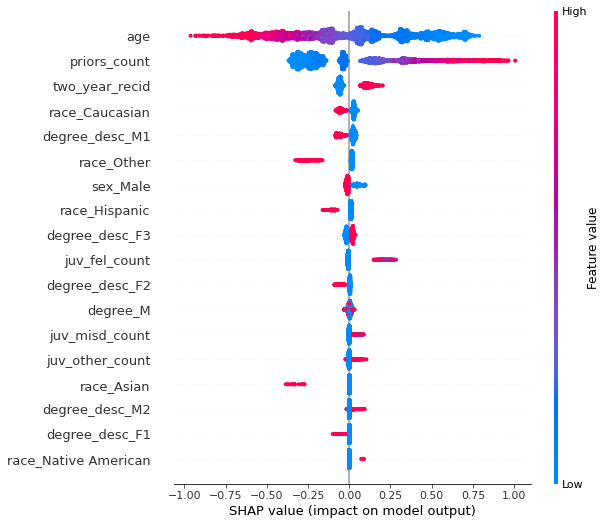

In [267]:
shap.summary_plot(shap_values, X_train)

- Each X-axis belongs to a single prediction made by the model. Each Y-axis represents a feature used in the model.
- Red color means higher value of a feature. Blue means lower value of a feature.
- The model did not ignore any of the feautures.
- "Age" is the most important feature when predicting "Decile Score". According to the model, the lower the age the higher Decile Score the person is predicted to get. This does make sense, as usually the younger criminal have such a hard time reinstate into the society and it's hard to leave the wrong path. We can see that also from looking at the impact of juvenile crime feautures in the model. The higher values of "juv_fel_count", "juv_misd_count", "juv_other_count" increase the predicted Decile Score of the individual.
- The second most important feature is the "priors_count" feature. The higher the number of prior arrests of an individual, the higher his or her decile_score is predicted to be. This makes perfect sense.
- Also, the "two_year_recid" feature importance makes completely sence. If the person did recid, he or she would be predicted to have a high decile score.
- One interesting insight from the graph above, from looking at the feature "sex_Male", we can see that females are more likely to have higher decile score.
- Another important insight from the graph above, we can observe that "race_Native American" is the least important feature in the model. While as out of all the race feature, "race_Caucasian" is the most important. And we can see that being Caucasian decreases the individual's decile score.
- From the graph, we can observe that out of all the crime degrees, M1 as degree description has the biggest importance in the model predicting the decile score.

## Classification model

In [268]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count
                    ],
                    axis=1)

target = df.two_year_recid

In [269]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = ran)

In [270]:
xgb_clf=best_est_clf_race

In [271]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, ...)

Since our model is tree-based, we use Tree Explainer

In [272]:
#compute SHAP values
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

### Global Interpretability

#### Variable Importance Plot - Global Interpretability

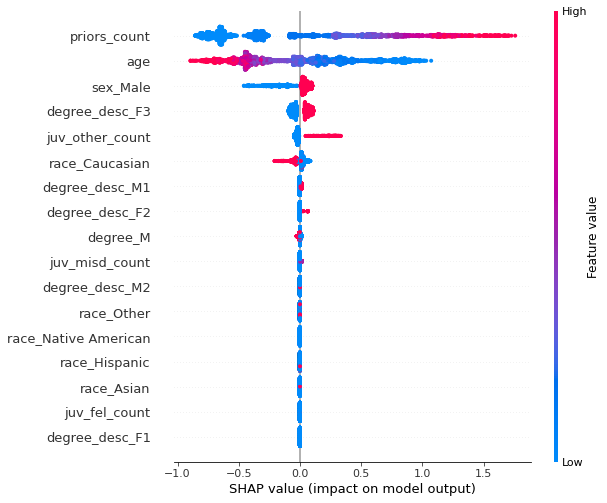

In [273]:
shap.summary_plot(shap_values, X_train)

- The y-axis indicates the variable name, in order of importance from top to bottom. The model's most important feature is priors_count. This makes perfect sense, as the higher the prior number of arrests, the higher the chance that he will recide again. A high level of the "priors_count" content has a high and positive impact on the decile score. The “high” comes from the red color, and the “positive” impact is shown on the X-axis.
- The second most important one is age. Just like the regression model, the lower the age the higher the chance the person will recide again. Tho, compared to "priors_count", "age"” is negatively correlated with the target variable.
- The third one is the gender feature. Males are predicted to have a higher chance of reciding.
- We can observe that for classification model, F3 degree crime is the most important degree crime. Also, being caucasian decreases the chance of reciding.
- The model ignored the following feautures: degree_desc_F1, juv_fel_count, race_Ascian, race_Native America etc.
- On the x-axis is the SHAP value. Indicates how much is the change in log-odds. From this number we can extract the probability.


#### SHAP Partial Dependence Plot — Global Interpretability

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome.
We will take a look into the most 2 important features: priors_count, age

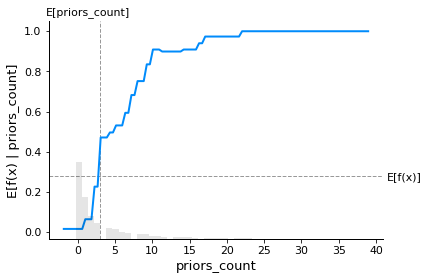

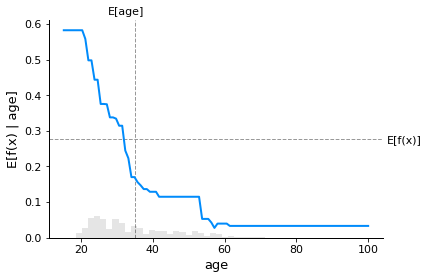

In [274]:
features_list = ["priors_count","age"]
for i in features_list:
    shap.plots.partial_dependence(
    i, xgb_clf.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
    )


Here on the X-axis, we can see the histogram of the distribution of the data, and the blue line in the plot is the average value of the model output which passes through a centre point which is also the intersection point of the expected value lines. The distance from the blueline to the expected value E[f(x)] is the shap value.

In the plots, the behaviour of the model for both the "priors_count" and the "age" is shown. 
- The prediction of a person who will recid increases when the "priors_count" increases. In another way, having more "priors_count" increases the odds of being labeled as reciding.
- Whereas for "age", an increase for this feature decreases the predicted probability of a person who will recid. Which also means that people who are older have better odds of not being labeled as reciding.
- For higher age from roughly 62, the prediction doesn’t change.



#### SHAP Dependence Plot — Global Interpretability

The dependence Plot function automatically includes another variable that your chosen variable interacts most with.

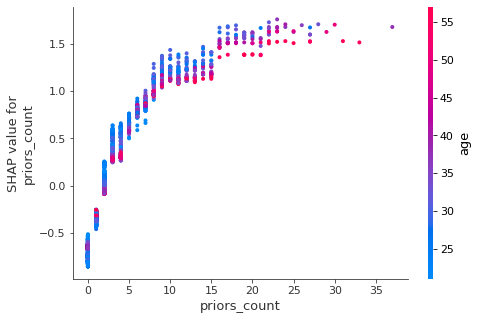

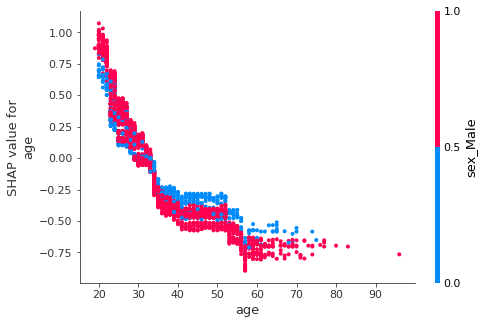

In [275]:
features_list = ["priors_count","age"]
for i in features_list:
    shap.dependence_plot(i,shap_values,X_train)

The function automatically includes another variable that your chosen variable interacts most with.
- The first plot shows there is an non-linear and positive trend between "priors_count" and the target variable "age". So the older the person, the higher priors_count that person has, which does make much sense
- The second plots shows there is a non-linear and negative trend between "age" and "sex_Male", and "age" interacts with "sex_Male" frequently.

#### Individual SHAP Value Plot — Local Interpretability

In [341]:
#random pick some of the value
random_picks = np.arange(1,3500,50) # Every 50 rows
X_output = X_train.iloc[random_picks]

In [342]:
#SHAP explainer values (NumPy array)
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_output)

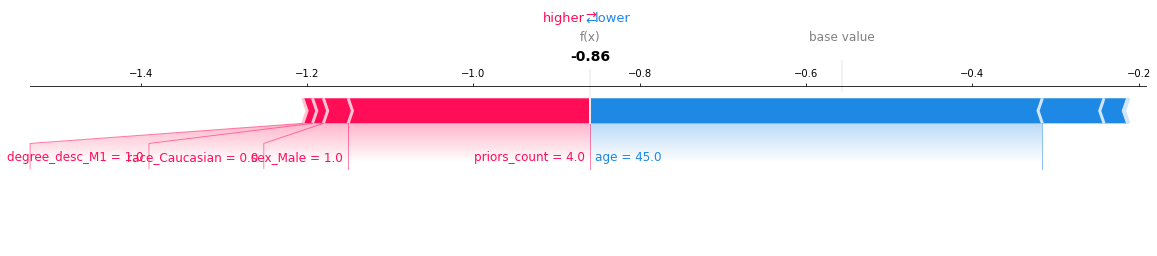

In [343]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[-1:], features=X_output.iloc[-1:], 
    feature_names=X_output.columns,
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [344]:
X_output.mean()

age                     32.771429
sex_Male                 0.800000
race_Asian               0.000000
race_Caucasian           0.300000
race_Hispanic            0.100000
race_Native American     0.000000
race_Other               0.042857
degree_M                 0.271429
degree_desc_F1           0.014286
degree_desc_F2           0.114286
degree_desc_F3           0.485714
degree_desc_M1           0.200000
degree_desc_M2           0.057143
priors_count             3.042857
juv_fel_count            0.057143
juv_misd_count           0.071429
juv_other_count          0.100000
dtype: float64

In [345]:
#base value
explainer.expected_value

-0.5570915

In [347]:
#base value probability from log odds
np.exp(explainer.expected_value)/(1+np.exp(explainer.expected_value))

0.3642207106842439

- Remember that the graph above shows us the log odds values.
- The output value -0.86 is the log odds for that observation.
- The base value -0.557 is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction of mean(y_output). The probability of base value is 0.364 (negative).
- Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
- "Priors_count" has a positive impact on the recid prediction. The prior_counts content of this observation is 4, which is higher than the average value 3.04. So it pushes the prediction to the right.
- "Age" has a negative impact on the predicted value. A higher than the average age (45 > 32.77) drives the prediction to the right.
- Also the fact that the person is not Causasian, is a male and and having degree description as M1 drives the prediction to the right.